In [50]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import lropt
import torch
from sklearn import datasets
import pandas as pd
from omegaconf import DictConfig
import os
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import hydra
import warnings
warnings.filterwarnings("ignore")

In [51]:
path = "/Users/irina.wang/Desktop/Princeton/Project2/lropt_experiments/lropt_experiments/port_parallel/plots/"
R = 5
etas = [0.01,0.05,0.08,0.10,0.12,0.15,0.18,0.20,0.23,0.25,0.30,0.33,0.35,0.40]
objs = [0.25,0.5,1]
seeds1 = [0,10,20,30,40]
seeds2 = [50,60,70,80,90]
foldername1 = "/Users/irina.wang/Desktop/Princeton/Project2/lropt_experiments/port_results/2025-04-28/10_0/"
foldername2 = "/Users/irina.wang/Desktop/Princeton/Project2/lropt_experiments/port_results/2025-04-28/10_1/"
quantiles = [0.25,0.75]

In [16]:
dfs_cat = []
running_ind = 0
for eta in etas:
    for obj in objs:
        newfolder = foldername1+str(running_ind)
        for seed in range(5):
            try:
                df = pd.read_csv(newfolder+'/'+str(seed)+"_vals.csv")
                dfs_cat.append(df)
            except:
                print(4,eta,obj,seed)
        running_ind += 1
running_ind = 0
for eta in etas:
    for obj in objs:
        newfolder = foldername2+str(running_ind)
        for seed in range(5):
            try:
                df = pd.read_csv(newfolder+'/'+str(seed)+"_vals.csv")
                dfs_cat.append(df)
            except:
                print(4,eta,obj,seed)
        running_ind += 1
dfs_cat = pd.concat(dfs_cat)

In [48]:
seed = 0
best_idx = np.argmin(dfs_cat[dfs_cat["seed"] == seed][abs(dfs_cat[dfs_cat["seed"] == seed]["valid_prob"] - 0.02)<=0.03]["valid_obj"])

In [49]:
dfs_cat[dfs_cat["seed"] == seed][abs(dfs_cat[dfs_cat["seed"] == seed]["valid_prob"] - 0.02)<=0.03].iloc[best_idx:best_idx+1]

,seed,rho,a_seed,eta,gamma,init_rho,valid_obj,valid_prob,test_obj,test_prob,nonrob_prob,nonrob_obj,scenario_probs,scenario_obj
27,0,1.644068,0,0.35,1.0,1,-0.8665,0.0475,-0.871735,0.046,0.598704,-0.930475,0.222056,-0.826786


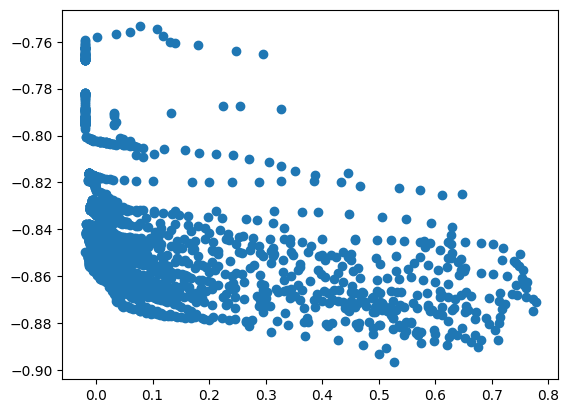

In [27]:
plt.scatter(dfs_cat[dfs_cat["seed"] == seed]["valid_prob"] - 0.02, dfs_cat[dfs_cat["seed"] == seed]["valid_obj"])

In [23]:
target = 0.02
best_idx = np.argmin(np.abs(np.array(dfs_cat[dfs_cat["seed"] == seed]["valid_prob"] - target)))

In [24]:
dfs_cat[dfs_cat["seed"] == seed].iloc[best_idx:best_idx+1]

,seed,rho,a_seed,eta,gamma,init_rho,valid_obj,valid_prob,test_obj,test_prob,nonrob_prob,nonrob_obj,scenario_probs,scenario_obj
19,0,1.305085,0,0.05,0.25,1,-0.823508,0.02,-0.819374,0.025,0.598704,-0.930475,0.222056,-0.826786


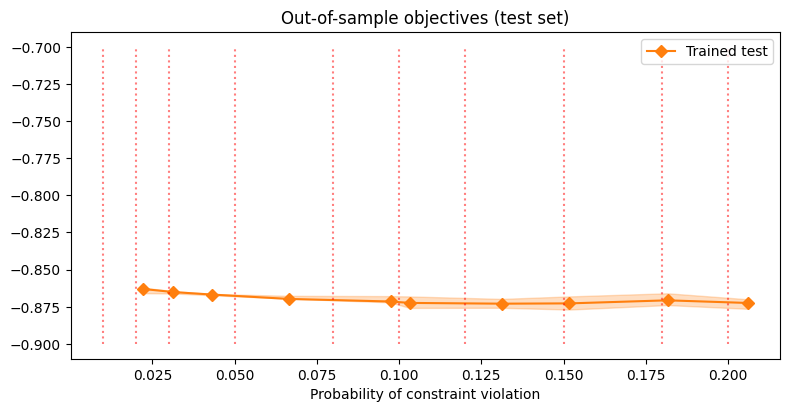

In [53]:
inds = {}
#target_list = [0.01,0.05,0.1,0.15,0.20]
dif = 0.01
target_list = [0.01,0.02,0.03,0.05,0.08,0.1,0.12,0.15,0.18,0.20]
dfs_best = {}
for target in target_list:
    inds[target] = []
    dfs_best[target] = []
    for seed in seeds1+seeds2:
        try:
            best_idx = np.argmin(dfs_cat[dfs_cat["seed"] == seed][abs(dfs_cat[dfs_cat["seed"] == seed]["valid_prob"] - target)<=dif]["valid_obj"])
            inds[target].append(best_idx)
            cur_df = dfs_cat[dfs_cat["seed"] == seed][abs(dfs_cat[dfs_cat["seed"] == seed]["valid_prob"] - target)<=dif].iloc[best_idx:best_idx+1]
            dfs_best[target].append(cur_df)
        except:
            print(seed)
    dfs_best[target] = pd.concat(dfs_best[target])   
plot_data = []
for target in target_list:
    data = {'test_prob': dfs_best[target]["test_prob"].mean(),'test_obj': dfs_best[target]["test_obj"].mean(),'0.25_test_obj': dfs_best[target]["test_obj"].quantile(0.25), '0.75_test_obj': dfs_best[target]["test_obj"].quantile(0.75)}
    data = pd.DataFrame(data, index=[0])
    plot_data.append(data)
plot_data = pd.concat(plot_data)
plot_data.to_csv(path+"plot_data.csv") 
# plt.rcParams.update({
#     "text.usetex":True,
#     "font.size":24,
#     "font.family": "sans-serif"
# })
def plot_best(plot_data,ylim=None):
    idx = 1
    plt.figure(figsize = (8,4))
    
    plt.plot(np.array(plot_data["test_prob"]),np.array(plot_data["test_obj"]), label = "Trained test" ,color = "tab:orange",marker = "D")
    plt.fill_between(np.array(plot_data["test_prob"]),np.array(plot_data["0.25_test_obj"]),np.array(plot_data["0.75_test_obj"]),alpha = 0.25, color = "tab:orange")

    plt.vlines(target_list,ymin = -0.9,ymax=-0.7,linestyles=":",color = "red",alpha = 0.5)
    # plt.vlines([0.03,0.05,0.10],ymin = -6,ymax=-2,linestyles=":",color = "red",alpha = 1)
    plt.legend(loc = "upper right")
    plt.xlabel("Probability of constraint violation")
    # plt.ylabel("Out-of-sample objective")
    plt.ylim(ylim)
    plt.tight_layout()
    # plt.xlim([-0.02,0.20])
    plt.title("Out-of-sample objectives (test set)")
    plt.savefig(path+"Test_objectives_best_all.pdf")
plot_best(plot_data)
